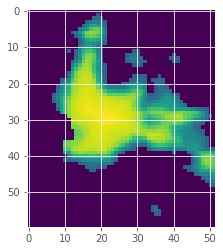

In [431]:
#Cargando librerías 
import importlib

import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd

import positioning_sensors as ps
import regionGrowing as rg
importlib.reload(ps)
importlib.reload(rg)

import network_fitness as netfit
importlib.reload(netfit)

from geneticalgorithm import geneticalgorithm as ga

plt.style.use("ggplot")

##

from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import rank

##

#cargamos imagenes en luminance e importance
ilumina = 'example/inputs/qro_light_th'
niveles = 'example/inputs/prioridades'
sigma_y = 0.7
sigma_x = 0.7
sigma = [sigma_y,sigma_x]

#Loading precalculated local and directed empirical variograms
data = pd.read_csv("th100_atol_15_dirdelta_1.csv")
variogram_set = np.array(data.iloc[:,3:])


#NLTI: luminance
luminance = ps.readIMG(ilumina)

#EAM: Environtmental attention map is the importance
EAM = ps.readIMG(niveles,invert=True)
#EAM[37][23]+=1

nonsat = ps.desaturate(luminance,th=62)

nonsat2 = sp.ndimage.filters.gaussian_filter(nonsat, sigma, mode='constant')

plt.imshow(nonsat)
plt.show()

In [432]:
import regionGrowing as rg
importlib.reload(rg)

<module 'regionGrowing' from '/Users/rodrigo/SourceCodes/git/optimal_light_sensor_location/regionGrowing.py'>

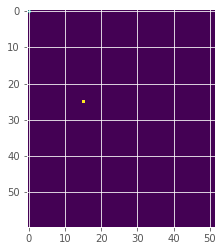

In [433]:
#si = (30,40)
#sj = (10,40)

GINT = G.astype(int)
z = np.zeros(GINT.shape)

si = (0,0)
sj = (np.random.randint(nonsat.shape[0]),np.random.randint(nonsat.shape[1]))
sj = (25,15)
z[si]=1
z[sj]=2

plt.imshow(z)

In [434]:
atol = 20
dtol = 0.5
params = {"type": "semivar", 
          "si": si, 
          "atol": atol, 
          "dtol": dtol}



In [435]:
sv = np.zeros(GINT.shape)
rG = rg.rGrowing(GINT) 

#Specific constraints for semivariance map

rG.setParams(params)

#getValidCoordinates
for i in range(GINT.shape[0]):
    for j in range(GINT.shape[1]):
        sj = (i,j)
        seed = sj
        set_ri = rG.getRegion(seed)
        z[sj] = np.mean([(nonsat2[si]-nonsat2[c])**2   for c in rG.coords])/2
z[si] = 0
        
        



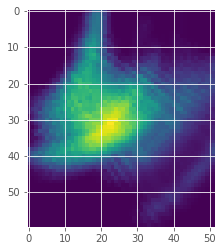

In [436]:
plt.imshow(z)

In [11]:


#gamma with gom

def gamma(I,si,grad_delta=15,h_delta= 2**(0.5)):
    """
    I: es la imagen original
    si: es la coordenada de referencia (central) 
    grad_delta angulo de tolerancia
    h_delta = distancia h de tolerancia
    
    
    
    """
    
    D = np.zeros(I.shape)
    E = np.zeros(I.shape)
    
    #observation value of the coordinate of interest
    #convertir si a tupla

    c = tuple(si)
    zi = I[c]
    
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            
            td = list()
            sj = np.array((i,j))
            grad = ps.angle(si,sj)
            
            #optimize gom with growing algorithm
            OM = ps.gom(si,sj,grad_delta,I)

                        
            #we get all the coordinates inside the oritentation mask
            ix = np.argwhere(OM == 1)

            #we get the main euclidean distance h from si to sj
            h = np.sum((si-sj)**2)**(0.5)
            

            for sk in ix:
                
              #  zk = I[sk[0]][sk[1]]
                zk = I[tuple(sk)]
                d = (np.sum((si-sk)**2))**(0.5)
                if (d<=(h+h_delta)) and (d>(h-h_delta)): 
                    td.append((zi-zk)**2)
                    
                    #if position k is inside the distance constrainst we set E[k1][k2] =1
                    if i == 30 and j== 50:
                        E[tuple(sk)]=1
                    
                        
            

            if len(td)>0: 
                D[i][j]= sum(td)/(2*len(td))
    D[c] = 0

    return D,E
    
    


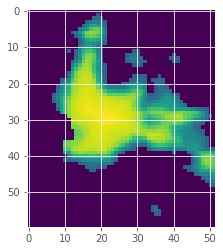

In [12]:
plt.imshow(nonsat)

In [13]:
import time

si = np.array((20,15))

t0 = time.perf_counter()

G,H = gamma(nonsat,si)

print(time.perf_counter()-t0)




106.40954028800479


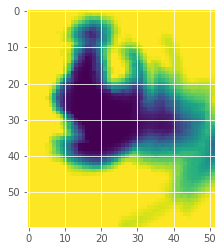

0.0

In [14]:
plt.imshow(G)
plt.show()
G[tuple(si)]

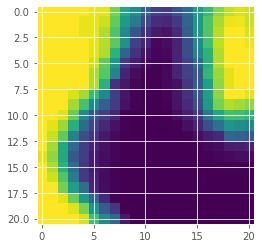

In [15]:
plt.imshow(G[si[0]-10:si[0]+11,si[1]-10:si[1]+11])

In [16]:
GINT = G.astype(int)

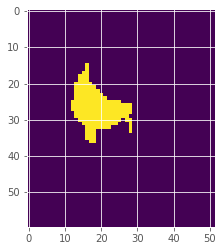

In [17]:
import itertools as it

stack = []
visit = np.zeros(G.shape)
visit[(si[0],si[1])] = 1
stack.append((si[0],si[1]))
r = list(range(-1,2))

#for i in range(200):
while True if stack else False:

    p = stack.pop()
    
    
    N = list([])

    pr = it.product(r,r)
    for px in pr:
        
        y = p[0]+px[0]
        y = 0 if y<=0 else y
        y = G.shape[0]-1 if y > G.shape[0]-1 else y
        
        x = p[1]+px[1]
        x = 0 if x < 0 else x
        x = G.shape[1]-1 if x > G.shape[1]-1 else x
        
        N.append((y,x))
        
    
    for n in N:
        
        #interchangeable condition
        reach = 1*(GINT.max()/100)
        if  (((GINT[n]-GINT[p])>=0.0 ) or (GINT[p]==0)) and (visit[n] == 0) and (GINT[n]<=reach):
            visit[n] = 1
            stack.append(n)
    
    
plt.imshow(visit)

In [18]:
import itertools as it


class rGrowing():
    
    
    
    
    
    def __init__(self,Img):
        '''
        
        '''

        self.Img = Img
        self.rng = list(range(-1,2))
    
    
    def getRegion(self,t):
        '''
        
        '''
        
        print(t)
    #    Img = self.Img
        #1) pila que recuerda las celdas por visitar
        self.stack = []
        
        #2) matriz que marca las celdas visitadas
        visit = np.zeros(self.Img.shape)
        
        #3) t es la tupla semilla y se marca como visitada
        visit[t] = 1
        
        #4) se guarda la tupla en la pila
        self.stack.append(t)
        
        #explorar solo si la pila tiene elementos
        while True if self.stack else False:

            N = list([])
            
            p = self.stack.pop()
            
            #explorar 8 celdas aledañas a la semilla
            pr = it.product(self.rng,self.rng)

            for px in pr:

                y = p[0]+px[0]
                
                #validamos los indices que no nos pasemos 
                y = 0 if y < 0 else y
                y = self.Img.shape[0]-1 if y > self.Img.shape[0]-1 else y

                
                x = p[1]+px[1]
                
                #validamos los indices que no nos pasemos 
                x = 0 if x < 0 else x
                x = self.Img.shape[1]-1 if x > self.Img.shape[1]-1 else x

                #si los indices son validos los agregamos a la lista N para explorarlos 
                N.append((y,x))

            #exploramos cada vecino valido
            for n in N:
           
                #la condicion de parada de crecimiento depende de si los vecinos n de p cumplen con la condicion 
                if self.validation(visit,n,p):
                    
                    # si es valida se marca la celda de la matriz visit como visitada
                    visit[n] = 1
                    
                    #se agrega a la pila para posteriormente explorar sus vecinos
                    self.stack.append(n)
            
        
        return visit  
                
    def validation(self,visit,n,p):
        '''
        Regresa True si es una celda valida
            
        '''
        per = 1
        reach = per*self.Img.max()/100
        return (((self.Img[n]-self.Img[p])>=0.0 ) or (self.Img[p]==0)) and (visit[n] == 0) and (self.Img[n]<=reach)
    
    def angleValidation(self,visit,n,p):
        '''
        
        '''
        
        #si n esta dentro del angulo y la distancia especificada, marcar como verdadero
        
        #para calcular la semivarianza de una celda se requiere 
        #angulo(pi,pj), 
        #tolerancia de angulo, 
        #distancia(pi,pj) 
        #tolerancia de distanciua
        # si pk esta dentro de esa región entonces es true.
        
        return True
        
        
        
        
        
    
    
    
    



In [38]:


GINT = G.astype(int)

rG = rg.rGrowing(GINT)    

t = tuple(si)
A = rG.getRegion(t)

plt.imshow(GINT*A)

ValueError: maximum supported dimension for an ndarray is 32, found 60

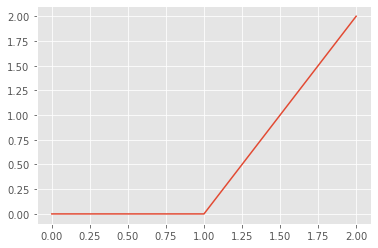

In [38]:
plt.plot(GINT[20,15:18])

In [20]:


r = list(range(-1,2))
pr = it.product(r,r)
pr

for px in pr:
    print(px)


(-1, -1)
(-1, 0)
(-1, 1)
(0, -1)
(0, 0)
(0, 1)
(1, -1)
(1, 0)
(1, 1)


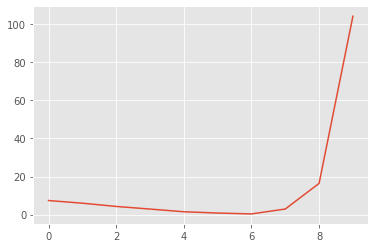

In [21]:
plt.plot(G[30:40,20])

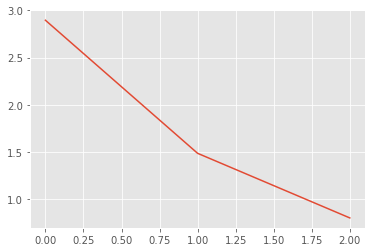

In [22]:


plt.plot(G[34-1:34+2,20])


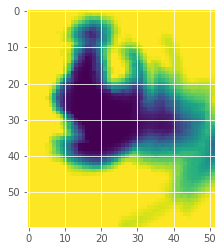

In [23]:
plt.imshow(G)

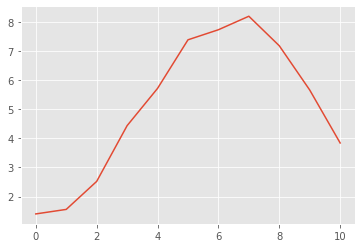

In [24]:
plt.plot(G[30,20-5:20+6])

In [25]:
G[30,20]

7.3827404234949245

In [463]:
#s = stack.pop()

#s
si

array([30, 20])

In [303]:
def emptystack(s):
    return True if s else False

In [305]:

c = 0
while (not emptystack(stack)) and (c<10):
    p = stack.pop()
    N = ps.getN(G,p[0],p[1])
    print(N)
    c+=1
    


# if stack else False

N

NameError: name 'N' is not defined

In [253]:


si

stack.append((4,5))
stack.append((40,59))



stack.pop()

(40, 59)

In [255]:
stack.pop()

IndexError: pop from empty list

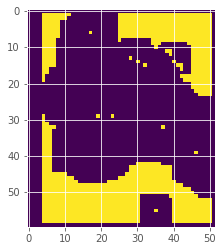

In [198]:
coords = peak_local_max(-G, footprint=np.ones((3, 3)), labels=(nonsat2>0))


mask = np.zeros(nonsat2.shape, dtype=bool)
mask[tuple(coords.T)] = True


plt.imshow(mask)

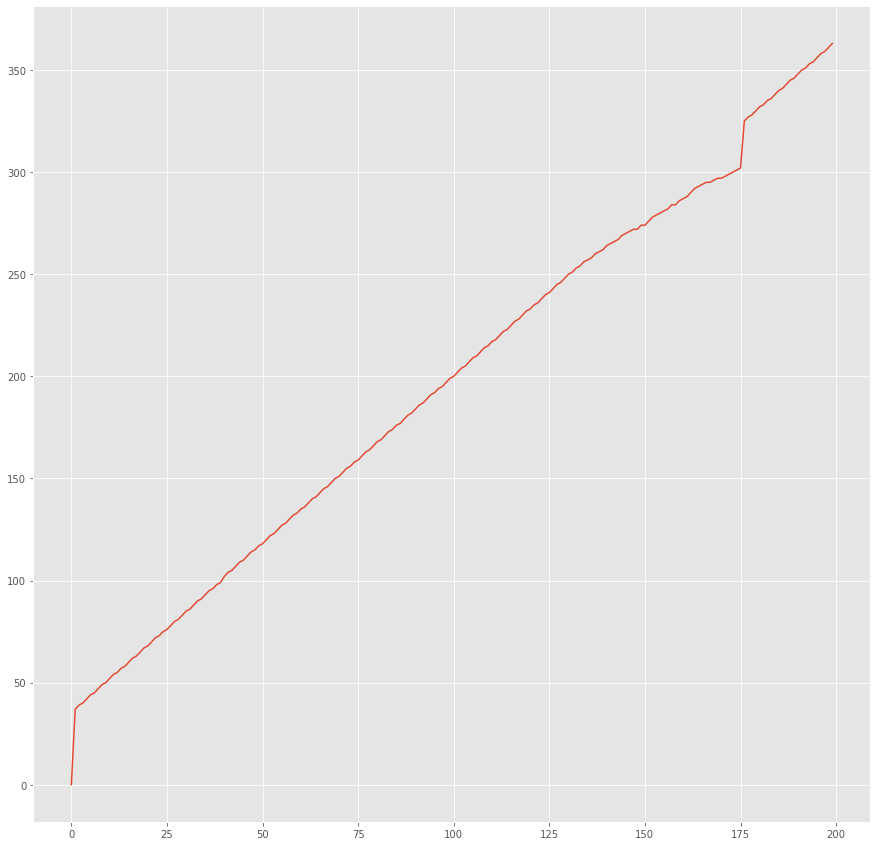

In [104]:
plt.figure(figsize=(15, 15))
plt.plot(r[:200])

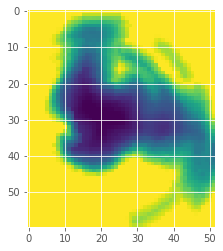

In [169]:
INTG = G.astype(int)
plt.imshow(INTG)

In [159]:
mask = np.zeros(nonsat2.shape, dtype=bool)
mask[tuple(coords.T)] = True

9.151921903599755e-05

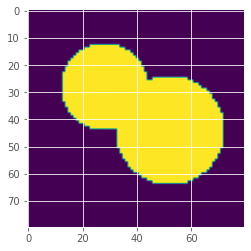

In [69]:
# Generate an initial image with two overlapping circles


x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)


plt.imshow(image)

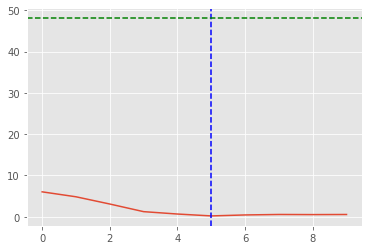

In [28]:
t = 5
plt.plot(G[si[0],si[1]-t:si[1]+t])
plt.axvline(x = t,color='b', linestyle='--')
plt.axhline(y = nonsat.max()**2/2/100*2,color='g', linestyle='--')

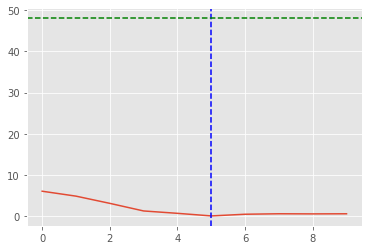

In [23]:
G[si[0],si[1]] = 0


plt.plot(G[si[0],si[1]-t:si[1]+t])
plt.axvline(x = t,color='b', linestyle='--')
plt.axhline(y = nonsat.max()**2/2/100*2,color='g', linestyle='--')

In [1436]:
G[si[0],si[1]-t:si[1]+t]

array([6.00485119, 4.80756182, 3.0534624 , 1.20563485, 0.62952009,
       0.        , 0.40748797, 0.52256815, 0.49276483, 0.51925194])

In [1412]:


GS = sp.ndimage.filters.gaussian_filter(G, sigma, mode='constant')



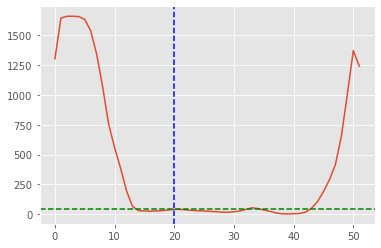

In [1417]:
(118*nonsat.shape[0]*nonsat.shape[1])/60/60/24/4

#plt.imshow(H)


plt.plot(GS[si[0],:])
plt.axvline(x = si[1],color='b', linestyle='--')
plt.axhline(y = nonsat.max()**2/2/100*2,color='g', linestyle='--')

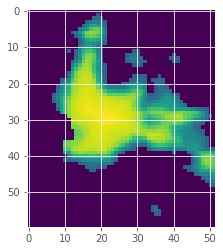

In [1415]:
plt.imshow(nonsat)

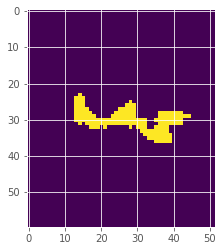

In [1254]:
plt.imshow(G<40)
plt.show()


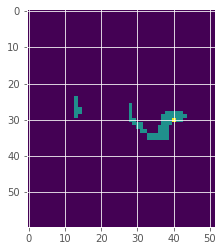

In [1257]:
mask = np.zeros(G.shape, dtype=bool)
mask[tuple(si.T)] = True

plt.imshow((G<(G.max()/100*1))*1 + mask)

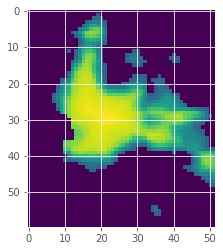

In [1236]:
plt.imshow(nonsat)

In [ ]:
#region(si,sj,ainf,asup,dinf,dsup)

#inicializar 1. push sj in P

#c = pop(P)
#n = getN(c)
#vn = validateN(n)
# mark valid cells
#push(n) push validates neighbors

#repeat 

In [1076]:
def condition_a(sk,s=(1,1),si=(1,1),sj=(1,1),ang=30,angtol=15,dinf=10,dsup=4):
    return 20+sk

def condition_b(sk):
    return 10
    
    
f = condition_a

f(1)
    
    


21

In [ ]:
class customGrowRegion():
    
    
    
    def condition(self,sk,s,si,sj,anginf,angsup,dinf,dsup):
        """
        
        regresa falso si sk no cumple con las condiciones
        """
        
    def validate(self,sk):
        
    
    
        

In [1329]:
si = np.array((30,20))
sj = np.array((20,10))
atol = 15
dtol = 0.5
condition(self,si,sj,atol,dtol,sk):
    angle = ps.angle(si,sj)
    angleinf = (angle-atol)
    anglesup = (angle+atol)

    #euclidean distance d(si,sj)
    d = np.sum((si-sj)**2)**(0.5)
    dinf = d-dtot
    dsup = d+dtol
    
    #sk is inside the angle and inside the distance#
    
    anglek = ps.angle(si,sk)
    distak = 
            
            # correction if angleinf is <0, the anglek are in [0,360)
            if (angleinf < 0) and ((anglek > (angleinf%360)) or (anglek<anglesup)) :
                A[i][j] = 1
                    
            if anglesup>=360 and ((anglek > angleinf) or (anglek<(anglesup%360))) :
#                anglesupp = anglesup%360
#                if (anglek > angleinf) or (anglek<(anglesup%360)):

                A[i][j] = 1          
            if (anglek<anglesup) and (anglek>angleinf):
                A[i][j] = 1

SyntaxError: invalid syntax (<ipython-input-1329-9c9a60104928>, line 5)

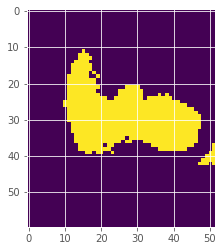

In [1261]:
G[si[0]][si[1]]=0
plt.imshow(G<500)



In [1273]:
((nonsat.max())**2)/2

2402.9469851812155

In [1274]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from matplotlib.pyplot import figure

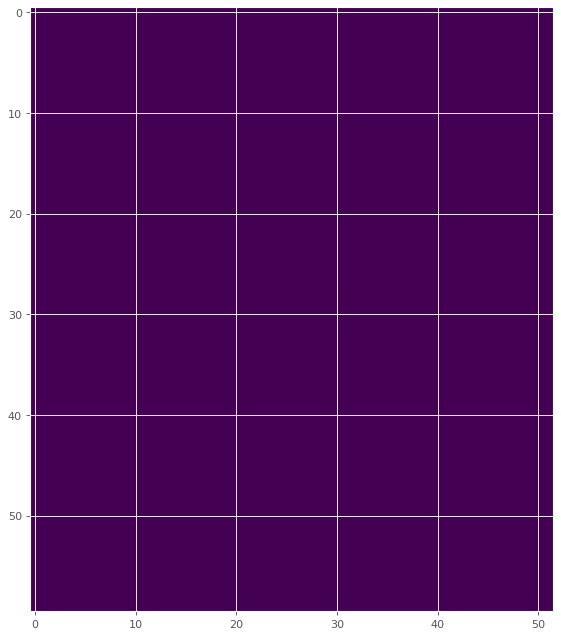

In [1276]:
mask = np.zeros(G.shape, dtype=bool)
mask[tuple(coords.T)] = True

markers, _ = ndi.label(mask)
labels = watershed(G, markers)

figure(figsize=(10, 10), dpi=80)
plt.imshow(labels)

{1}

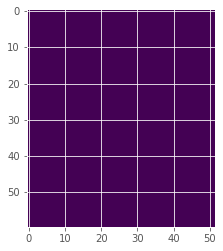

In [1293]:
#seeds is a bidim matrix with true labels in seeds
coords =  si

mask = np.zeros(G.shape, dtype=bool)
mask[tuple(coords.T)] = True

markers, _ = ndi.label(mask)


labels = watershed(G**2, markers)

#figure(figsize=(10, 10), dpi=80)
#plt.imshow(labels+seeds*10)

plt.imshow(labels)
set(labels.flatten())

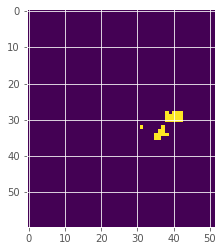

In [1328]:
plt.imshow(G<8)

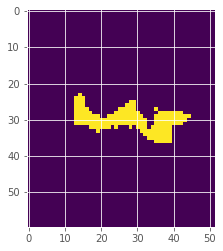

In [1320]:
plt.imshow(G<=50)

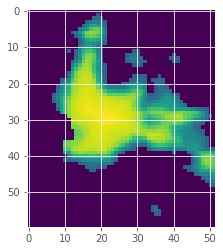

In [1321]:
plt.imshow(nonsat)

In [1110]:
coords = si
mask = np.zeros(G.shape, dtype=bool)
mask[tuple(coords.T)] = True

markers, _ = ndi.label(mask)
labels = watershed(G, markers, mask=nonsat)

figure(figsize=(10, 10), dpi=80)

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

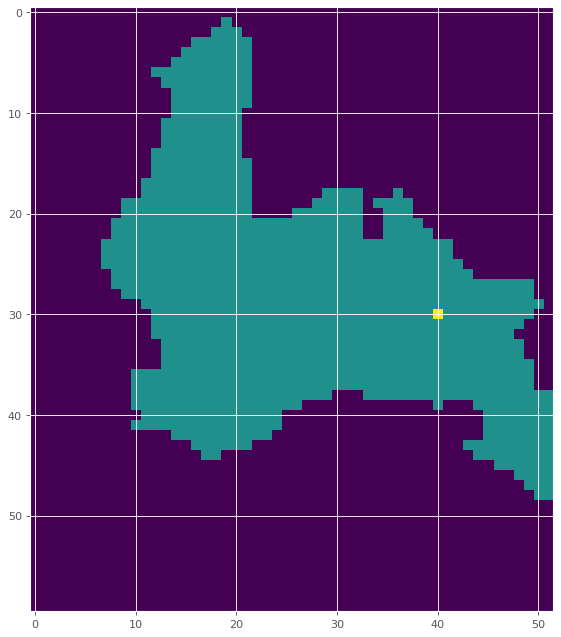

In [1337]:
figure(figsize=(10, 10), dpi=80)
mask = np.zeros(nonsat.shape, dtype=bool)
mask[tuple(coords.T)] = True

figure(figsize=(10, 10), dpi=80)
markers, _ = ndi.label(mask)
labels = watershed(G, markers, mask=(nonsat>0))
plt.imshow(labels+markers)
plt.show()

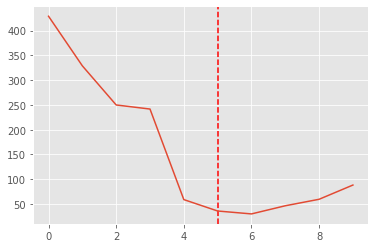

In [1336]:
plt.axvline(x=5, color='r', linestyle='--')
plt.plot(G[si[0]-5:si[0]+5,20])



In [1338]:
si

array([30, 40])

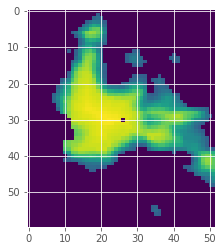

In [563]:
nonsat[30][26]=0

plt.imshow(nonsat)

In [317]:
def spatialSemivariance(si,I):
    """
    Returns gamma(si)
    """
    
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            sj=np.array(i,j)
            
            

In [272]:
sj[0]

50

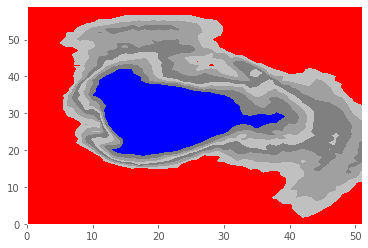

In [1182]:
x = np.arange(1, 10)
y = x.reshape(-1, 1)
h = x * y

cs = plt.contourf(np.flip(G,axis=0),
    colors=['#808080', '#A0A0A0', '#C0C0C0'], extend='both')
cs.cmap.set_over('red')
cs.cmap.set_under('blue')
cs.changed()

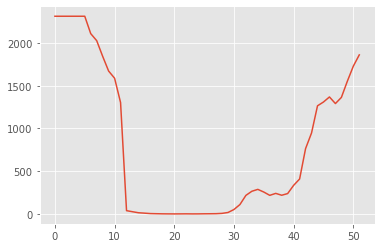

In [1183]:
plt.plot(G[30][:])

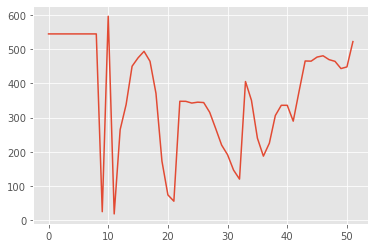

In [1014]:
plt.plot(G[20][:])

In [1]:
#referencias
#https://es.calcuworld.com/calculadoras-matematicas/trigonometria/arcotangente/
#https://www.engineeringtoolbox.com/slope-degrees-gradient-grade-d_1562.html

#simple growing region algoritm
#https://developpaper.com/simple-implementation-of-region-growing-in-python/

```hola```